# Prediction of number of deaths/infected through COVID-19

This predictions are done on 04/04/2020, using data until this date.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from datetime import datetime,timedelta

## Data

The data comes from here: https://github.com/CSSEGISandData/COVID-19/

In [2]:
df_recovered=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
df_recovered.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,2,2,2,2,2,2,5,5,10,10
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,17,17,31,31,33,44,52,67,76,89
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,65,29,29,31,31,37,46,61,61,62
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,1,1,1,1,10,10,10,10,16
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1


In [3]:
df_confirmed=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_confirmed.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,84,94,110,110,120,170,174,237,273,281
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,146,174,186,197,212,223,243,259,277,304
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,302,367,409,454,511,584,716,847,986,1171
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,188,224,267,308,334,370,376,390,428,439
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,3,4,4,5,7,7,7,8,8,8


In [4]:
df_dead=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_dead.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,2,4,4,4,4,4,4,4,6,6
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,5,6,8,10,10,11,15,15,16,17
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,21,25,26,29,31,35,44,58,86,105
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,3,3,3,6,8,12,14,15,16
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,2,2,2,2,2,2


## Data manipulation

So far, I pick up five different countries to study:

- China (The first one, and therefore the reference to compare to).
- Italy (One of the biggest ones, and much more similar in social, politics and size with other Europen countries).
- Spain
- France
- US (Summing all the data from all the states together).

In [5]:
df_confirmed.loc['WholeUS'] = df_confirmed[df_confirmed['Country/Region']=='US'].sum()
df_confirmed.loc[df_confirmed.index=='WholeUS','Country/Region']='WholeUS'
df_dead.loc['WholeUS'] = df_dead[df_dead['Country/Region']=='US'].sum()
df_dead.loc[df_dead.index=='WholeUS','Country/Region']='WholeUS'

In [6]:
df_confirmed.loc[df_confirmed.index=='WholeUS',:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
WholeUS,0,WholeUS,37.0902,-95.7129,1,1,2,2,5,5,...,65778,83836,101657,121478,140886,161807,188172,213372,243453,275586


In [7]:
df_confirmed[(df_confirmed['Country/Region']=='France') & (df_confirmed['Province/State'].isnull())]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
116,NaN,France,46.2276,2.2137,0,0,2,3,3,3,...,25233,29155,32964,37575,40174,44550,52128,56989,59105,64338


In [8]:
def select_countries(df):
    df = df[(df['Country/Region']=='Spain') | (df['Country/Region']=='Italy') | 
                            ((df['Country/Region']=='France') & (df['Province/State'].isnull()))
                            |((df['Country/Region']=='China') & (df['Province/State']=='Hubei')) |
           (df['Country/Region']=='WholeUS')]
    return df

In [9]:
def prepare_dataframe(df,label='contagious'):
    """
    I create a new column "DayStart"+Country, which sets to 1 the day the number of contagious or deads equal the same as China on 1/22/20.
    This is done to be able to compare past curves (such as in China or Italy), with present ones (France, Spain or US)
    """
    if label=='contagious':
        nspain=43
        nfrance=42
        nitaly=34
        nus=44
    if label=='death':
        nspain=43
        nfrance=44
        nitaly=35
        nus=44
        
    df = df.set_index('Country/Region').drop(['Lat','Long','Province/State'],axis=1).T
    df = df.reset_index()
    df['DayStartChina']= df.index +1
    df['DayStartSpain']= df.index -nspain
    df['DayStartFrance']= df.index -nfrance
    df['DayStartItaly']= df.index -nitaly
    df['DayStartUS']= df.index -nus
    
    return df
        

In [10]:
df_contag  = select_countries(df_confirmed)
df_death  = select_countries(df_dead)

In [11]:
df_contag  = prepare_dataframe(df_contag,label='contagious')
df_death  = prepare_dataframe(df_death,label='death')

In [12]:
df_contag.head()

Country/Region,index,China,France,Italy,Spain,WholeUS,DayStartChina,DayStartSpain,DayStartFrance,DayStartItaly,DayStartUS
0,1/22/20,444,0,0,0,1,1,-43,-42,-34,-44
1,1/23/20,444,0,0,0,1,2,-42,-41,-33,-43
2,1/24/20,549,2,0,0,2,3,-41,-40,-32,-42
3,1/25/20,761,3,0,0,2,4,-40,-39,-31,-41
4,1/26/20,1058,3,0,0,5,5,-39,-38,-30,-40


## Model the data

As this is a Pandemic, we know it grows as an Exponential, until it reaches the inflexion point and it becomes a logistic function. I'm then going to consider both models for our analysis. 

In [13]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))


In [14]:
def plot_normalized_day0(df,label='Contagious',fit=True):
    
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(1, 1, 1)

    
    plt.plot(df['DayStartSpain'][df['DayStartSpain']>0],df['Spain'][df['DayStartSpain']>0],'b*')
    plt.plot(df['DayStartFrance'][df['DayStartFrance']>0],df['France'][df['DayStartFrance']>0],'yo')
    plt.plot(df['DayStartUS'][df['DayStartUS']>0],df['WholeUS'][df['DayStartUS']>0],'ms')
    plt.plot(df['DayStartItaly'][df['DayStartItaly']>0],df['Italy'][df['DayStartItaly']>0],'gv')
    plt.plot(df['DayStartChina'],df['China'],'r+')


    if fit:
        xxS = np.array(df['DayStartSpain'][df['DayStartSpain']>0])
        yyS = np.array(df['Spain'][df['DayStartSpain']>0])
        xxSi=xxS[xxS<20]
        yySi=yyS[xxS<20]
        popt, pcov = curve_fit(exponential_model, xxSi, yySi, bounds=([-100,-1.,-100], [100., 1., 100.]))        
        poptS, pcovS = curve_fit(logistic_model, xxS, yyS, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxSi, exponential_model(xxSi, *popt), 'b-')#
        plt.plot(xxS, logistic_model(xxS, *poptS), 'b--')#
        print('Spain Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('Spain Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptS))

        xxF = np.array(df['DayStartFrance'][df['DayStartFrance']>0])
        yyF = np.array(df['France'][df['DayStartFrance']>0])
        popt, pcov = curve_fit(exponential_model, xxF, yyF, bounds=([-100,-1.,-100], [100., 1., 100.]))
        plt.plot(xxF, exponential_model(xxF, *popt), 'y-')#
        poptF, pcovF = curve_fit(logistic_model, xxF, yyF, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxF, logistic_model(xxF, *poptF), 'y--')#
        print('France Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('France Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptF))

        xxW = np.array(df['DayStartUS'][df['DayStartUS']>0])
        yyW = np.array(df['WholeUS'][df['DayStartUS']>0])
        popt, pcov = curve_fit(exponential_model, xxW, yyW, bounds=([-100,-1.,-100], [100., 1., 100.]))
        plt.plot(xxW, exponential_model(xxW, *popt), 'm-')#
        poptW, pcovW = curve_fit(logistic_model, xxW, yyW, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxW, logistic_model(xxW, *poptW), 'm--')#
        print('US Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('US Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptW))

        xxI = np.array(df['DayStartItaly'][df['DayStartItaly']>0])
        yyI = np.array(df['Italy'][df['DayStartItaly']>0])
        xxIi=xxI[xxI<20]
        yyIi=yyI[xxI<20]
        popt, pcov = curve_fit(exponential_model, xxIi, yyIi) 
        plt.plot(xxIi, exponential_model(xxIi, *popt), 'g-')
        poptI, pcovI = curve_fit(logistic_model, xxI, yyI, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxI, logistic_model(xxI, *poptI), 'g--')#
        print('Italy Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('Italy Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptI))

        xxC = np.array(df['DayStartChina'])
        yyC = np.array(df['China'])
        xxCi=xxC[xxC<20]
        yyCi=yyC[xxC<20]
        popt, pcov = curve_fit(exponential_model, xxCi, yyCi) 
        plt.plot(xxCi, exponential_model(xxCi, *popt), 'r-')
        poptC, pcovC = curve_fit(logistic_model, xxC, yyC, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxC, logistic_model(xxC, *poptC), 'r--')#
        print('China Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('China Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptC))

    ax.set_yscale('log')
    plt.xticks(rotation=45)
    plt.legend(['Spain','France','US','Italy','China','Spain Exponential Model','Spain Logistic Model',
                'France Exponential Model','France Logistic Model','US Exponential Model','US Logistic Model',
            'Italy Exponential Model', 'Italy Logistic Model','China Exponential Model', 'China Logistic Model'])
    plt.xlabel('Day from start of multiple '+label)
    plt.ylabel('N '+label)
    plt.show()

Spain Exponential fit: a=20.794, b=0.187, c=-21.683
Spain Logistic fit: a=4.554, b=23.477, c=153079.910
France Exponential fit: a=28.339, b=0.119, c=-35.592
France Logistic fit: a=5.506, b=27.087, c=102337.946
US Exponential fit: a=24.860, b=0.165, c=-28.822
US Logistic fit: a=3.984, b=25.852, c=428140.148
Italy Exponential fit: a=12.334, b=0.185, c=-22.123
Italy Logistic fit: a=5.616, b=27.792, c=136673.545
China Exponential fit: a=23.779, b=0.170, c=-23.587
China Logistic fit: a=4.262, b=19.695, c=67748.289


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


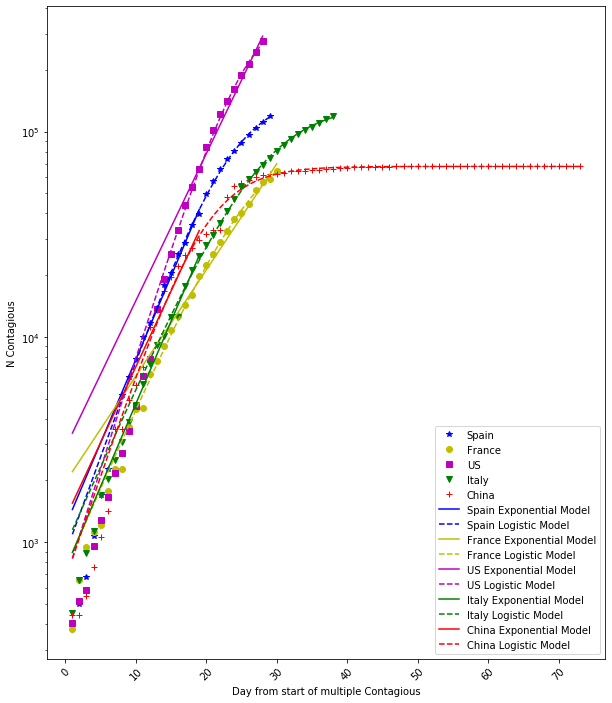

In [15]:
plot_normalized_day0(df_contag,label='Contagious')

Spain Exponential fit: a=12.257, b=0.255, c=-2.458
Spain Logistic fit: a=3.783, b=24.234, c=14126.372
France Exponential fit: a=13.555, b=0.183, c=-5.622
France Logistic fit: a=5.448, b=55.511, c=999970.732
US Exponential fit: a=10.905, b=0.221, c=-1.406
US Logistic fit: a=3.863, b=31.532, c=24830.348
Italy Exponential fit: a=8.738, b=0.224, c=-5.777
Italy Logistic fit: a=5.332, b=29.855, c=18228.550
China Exponential fit: a=11.917, b=0.160, c=-8.269
China Logistic fit: a=6.573, b=25.437, c=3140.627


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


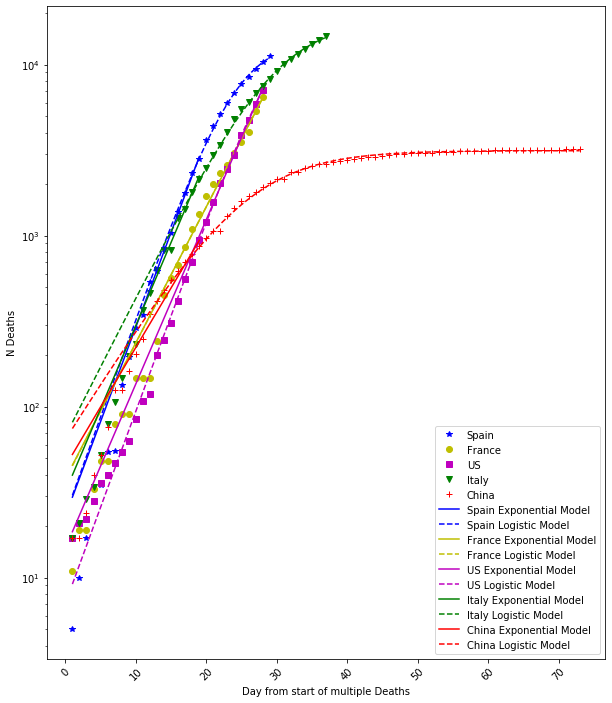

In [16]:
plot_normalized_day0(df_death,label='Deaths')

We have here fitted exponential and logistic models to the curves, and plot the above results. Let's notice than the deaths curves are much more realistic than the infected, as this depends very much on the existence of tests and different politics to measure those.

For the first time, countries such as Spain and France start to have a better logistic fit than exponential to date (31/03/2020).

## Extrapolation of the logistic model to 90 days after the first deaths/contagions

Let's use now only logistic models and assume there is going to be an inflection point of around ~25 days after the first contagions/deaths, to predict what will happen in 90 days after the first deaths / contagions.

Of course, this assumes that this inflection point is the same for all countries, and we know this will change depending on the strictness of the measurements that the different countries will take, so this is only a possible (and simple) scenario of what will happen.

In [17]:
def plot_extrapolated_logistic_model(df,label='Contagious',inflexion=25):
    
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(1, 1, 1)

    
    plt.plot(df['DayStartSpain'][df['DayStartSpain']>0],df['Spain'][df['DayStartSpain']>0],'b*')
    plt.plot(df['DayStartFrance'][df['DayStartFrance']>0],df['France'][df['DayStartFrance']>0],'yo')
    plt.plot(df['DayStartUS'][df['DayStartUS']>0],df['WholeUS'][df['DayStartUS']>0],'ms')
    plt.plot(df['DayStartItaly'][df['DayStartItaly']>0],df['Italy'][df['DayStartItaly']>0],'gv')
    plt.plot(df['DayStartChina'],df['China'],'r+')

    xxPredictions = np.arange(0, 90)    
    
    xxS = np.array(df['DayStartSpain'][df['DayStartSpain']>0])
    yyS = np.array(df['Spain'][df['DayStartSpain']>0])
    popt, pcov = curve_fit(logistic_model, xxS, yyS, bounds=([4,inflexion-1,100], [10., inflexion+1, 1000000.]))       
#    popt, pcov = curve_fit(logistic_model, xxS, yyS, bounds=([4,1,100], [10., 100, 1000000.]))       
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'b-')
    print('Spain',popt[0],popt[1],popt[2])
    
    xxF = np.array(df['DayStartFrance'][df['DayStartFrance']>0])
    yyF = np.array(df['France'][df['DayStartFrance']>0])
    popt, pcov = curve_fit(logistic_model, xxF, yyF, bounds=([4,inflexion-1,100], [10., inflexion+1, 100000.]))
#    popt, pcov = curve_fit(logistic_model, xxF, yyF, bounds=([4,1,100], [10., 100, 100000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'y-')#
    print('France',popt[0],popt[1],popt[2])
    
    xxW = np.array(df['DayStartUS'][df['DayStartUS']>0])
    yyW = np.array(df['WholeUS'][df['DayStartUS']>0])
    popt, pcov = curve_fit(logistic_model, xxW, yyW, bounds=([4,inflexion-10,100], [10., inflexion+10, 1000000.])) 
#    popt, pcov = curve_fit(logistic_model, xxW, yyW, bounds=([4,1,100], [10.,100, 1000000.])) 
    plt.plot(xxPredictions, logistic_model(xxPredictions, *popt), 'm-')#
    print('US',popt[0],popt[1],popt[2])
    
    xxI = np.array(df['DayStartItaly'][df['DayStartItaly']>0])
    yyI = np.array(df['Italy'][df['DayStartItaly']>0])
    popt, pcov = curve_fit(logistic_model, xxI, yyI, bounds=([4,inflexion-1,100], [10., inflexion+1, 1000000.]))
#    popt, pcov = curve_fit(logistic_model, xxI, yyI, bounds=([4,1,100], [10., 100, 1000000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'g-')#
    print('Italy',popt[0],popt[1],popt[2])
        
    xxC = np.array(df['DayStartChina'])
    yyC = np.array(df['China'])
    popt, pcov = curve_fit(logistic_model, xxC, yyC, bounds=([4,10,100], [10., 100, 100000.]))
#    popt, pcov = curve_fit(logistic_model, xxC, yyC, bounds=([4,1,100], [10., 100, 100000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'r-')#
    print('China',popt[0],popt[1],popt[2])
    
    ax.set_yscale('log')
    plt.xticks(rotation=45)
    plt.legend(['Spain','France','US','Italy','China','Spain Logistic Model','France Logistic Model',
                'US Logistic Model','Italy Logistic Model', 'China Logistic Model'])
    plt.xlabel('Day from start of multiple '+label)
    plt.ylabel('N '+label)
    plt.show()

Spain 5.344262267770107 26.000000000000004 192277.87745151515
France 5.438266081867196 26.827034731179154 99999.99999999997
US 4.000000000000001 25.90393346091074 430778.42782778625
Italy 5.6159548254126115 27.792243273356522 136673.53559712291
China 4.26163058247619 19.695383875745264 67748.29010069607


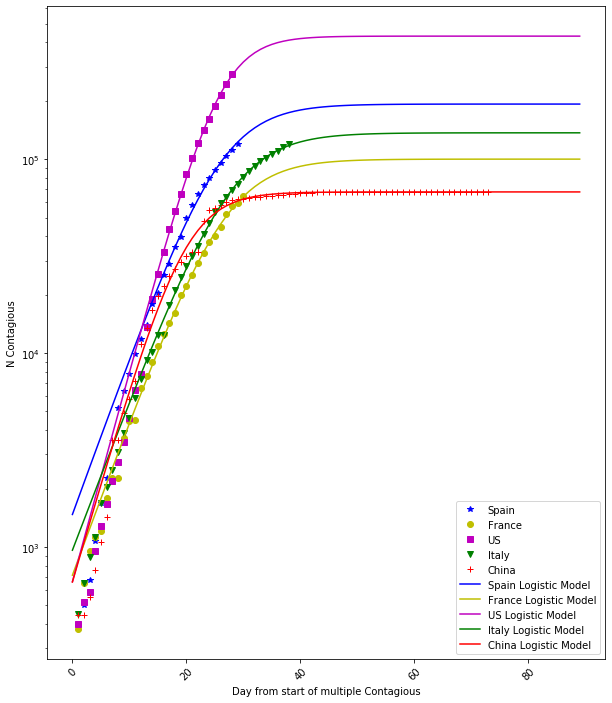

In [18]:
plot_extrapolated_logistic_model(df_contag,label='Contagious',inflexion=27)

Spain 4.353397703830549 26.000000000000004 17083.00289683812
France 4.078335780241038 27.999999999999932 11997.200828832323
US 4.000000000000005 32.70882445920806 30259.296000089238
Italy 4.64786503510196 27.999999999999996 15805.180040500018
China 6.573438404844444 25.43683970393542 3140.6271586696926


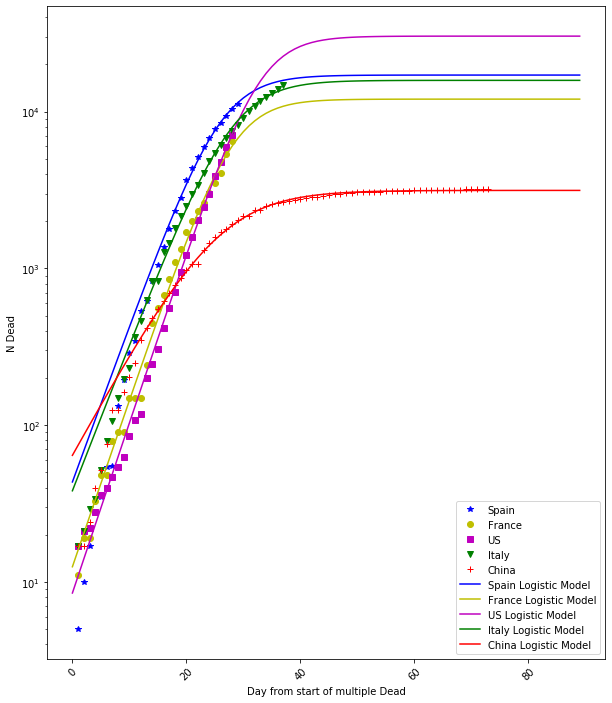

In [19]:
plot_extrapolated_logistic_model(df_death,label='Dead',inflexion=27)

I have used here, an inflexion point of 27 days for deaths, 26 for infected, based on the data from Italy.  This might change or not, based on the different measures each country takes. Based on this, the predictions are:

- ~13000 deaths in Spain, ~ 12000 in Italy, ~10000 in France and ~30000 in the US (where I had to set a much higher inflexion point of ~26+10). In China, the official number of deaths are ~2000.
- The number of infected would be of the order of ~200.000 per Spain, 120.000 per Italy, 100.000 per France and ~400.000 for the US. China would have 60.000. 
- Of course these numbers are based on the official number of infected and deaths but, this is very related to the different politics in terms of testing people and counting deaths due to CoronaVirus. Probably this is just a inferior limit.

## Things to do

- Add more countries
- Normalize by the population of each country / number of bed in hospitals per country.
- Try different scenarios (such as inflexion points)
- Continously update with new data (and hopefully expect that this will change!)